In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import re
import os
import glob 
import json
import joblib
import warnings
import matplotlib.pyplot as plt

# Scikit-learn imports
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor

# XGBoost
import xgboost as xgb

# Optuna for hyperparameter optimization
import optuna
from optuna.integration import OptunaSearchCV

# SHAP for explainability
import shap

# Disable file validation warning
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# Multiple Target Regression using XGBoost

This notebook trains a multi-output XGBoost regressor to predict all inequality indicators simultaneously.

In [2]:
# Target options - we'll use all three for multi-output regression
TARGETS = {
    'GINI': 'SI.POV.GINI',      # Gini coefficient (measure of inequality)
    'top10': 'SI.DST.10TH.10',  # Top 10% wealth share
    'bottom10': 'SI.DST.FRST.10' # Bottom 10% wealth share
}

TARGET_LIST = list(TARGETS.values())

In [3]:
print('Date ranges available:')
for file in glob.glob('input/imputed/*.csv'):
    date_start = file.split('/')[-1].split('.')[0].split('_')[-3]
    date_end = file.split('/')[-1].split('.')[0].split('_')[-1]
    print(f"{date_start}_to_{date_end}")

Date ranges available:
2022_to_2023
1970_to_2020
2000_to_2020
1960_to_2024


In [4]:
# select a date range
selected_date_range = '2000_to_2020'

# Configuration

Define all path variables here for easy modification

In [5]:
# Random seed for reproducibility
SEED = 20250406

# Input paths
INPUT_DIR = 'input'
IMPUTED_DIR = f'{INPUT_DIR}/imputed'
TRANSFORMED_DIR = f'{INPUT_DIR}/transformed'
TRAIN_TEST_VAL_DIR = f'{INPUT_DIR}/train_test_val'
REFERENCE_DIR = 'output/reference'

# Data files
DATA_FILE = f'{IMPUTED_DIR}/df_wide_knn_imputed_{selected_date_range}.csv'
TARGET_FILE = f'{TRANSFORMED_DIR}/df_wide_targets_{selected_date_range}.csv'
INDICATOR_LOOKUP_FILE = f'{REFERENCE_DIR}/indicator_lookup.csv'

# Extract implied date range from data file name
DATE_RANGE = re.search(r'(\d+)_to_(\d+)', DATA_FILE).group(0)

# Set file suffix for output files based on the selected targets
FILE_SUFFIX = f"multi_target_{DATE_RANGE}"

# Output paths
OUTPUT_DIR = 'output'
MODELS_DIR = f'{OUTPUT_DIR}/models'
PREDICTIONS_DIR = f'{OUTPUT_DIR}/predictions'
FEATURE_IMPORTANCE_DIR = f'{OUTPUT_DIR}/feature_importance'

# Output files
# - Base model outputs
MODEL_FILE = f'{MODELS_DIR}/xgb_base_model_{FILE_SUFFIX}.pkl'
PREDICTIONS_FILE = f'{PREDICTIONS_DIR}/xgb_base_predictions_{FILE_SUFFIX}.csv'
FEATURE_IMPORTANCES_FILE = f'{FEATURE_IMPORTANCE_DIR}/xgb_base_feature_importances_{FILE_SUFFIX}.csv'

# - Best model outputs
BEST_MODEL_FILE = f'{MODELS_DIR}/xgb_tuned_model_{FILE_SUFFIX}.pkl'
BEST_PREDICTIONS_FILE = f'{PREDICTIONS_DIR}/xgb_tuned_predictions_{FILE_SUFFIX}.csv'
BEST_FEATURE_IMPORTANCES_FILE = f'{FEATURE_IMPORTANCE_DIR}/xgb_tuned_feature_importances_{FILE_SUFFIX}.csv'
BEST_PARAMS_FILE = f'{MODELS_DIR}/xgb_tuned_model_params_{FILE_SUFFIX}.json'

# Create output directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PREDICTIONS_DIR, exist_ok=True)
os.makedirs(FEATURE_IMPORTANCE_DIR, exist_ok=True)

# Print configuration summary
print("\n=== CONFIGURATION SUMMARY ===")
print(f"Targets: {TARGET_LIST}")
print(f"Date Range: {DATE_RANGE}")
print(f"Random Seed: {SEED}")
print("\n=== Input Files ===")
print(f"Data File: {DATA_FILE}")
print(f"Indicator Lookup: {INDICATOR_LOOKUP_FILE}")
print("\n=== Output Files ===")
print(f"Base Model: {MODEL_FILE}")
print(f"Base Predictions: {PREDICTIONS_FILE}")
print(f"Base Feature Importances: {FEATURE_IMPORTANCES_FILE}")
print(f"Tuned Model: {BEST_MODEL_FILE}")
print(f"Tuned Predictions: {BEST_PREDICTIONS_FILE}")
print(f"Tuned Feature Importances: {BEST_FEATURE_IMPORTANCES_FILE}")
print(f"Tuned Model Parameters: {BEST_PARAMS_FILE}")
print("\n=== Directories ===")
print(f"Input Directory: {INPUT_DIR}")
print(f"Imputed Data Directory: {IMPUTED_DIR}")
print(f"Transformed Data Directory: {TRANSFORMED_DIR}")
print(f"Train/Test/Val Directory: {TRAIN_TEST_VAL_DIR}")
print(f"Reference Directory: {REFERENCE_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Models Directory: {MODELS_DIR}")
print(f"Predictions Directory: {PREDICTIONS_DIR}")
print(f"Feature Importance Directory: {FEATURE_IMPORTANCE_DIR}")


=== CONFIGURATION SUMMARY ===
Targets: ['SI.POV.GINI', 'SI.DST.10TH.10', 'SI.DST.FRST.10']
Date Range: 2000_to_2020
Random Seed: 20250406

=== Input Files ===
Data File: input/imputed/df_wide_knn_imputed_2000_to_2020.csv
Indicator Lookup: output/reference/indicator_lookup.csv

=== Output Files ===
Base Model: output/models/xgb_base_model_multi_target_2000_to_2020.pkl
Base Predictions: output/predictions/xgb_base_predictions_multi_target_2000_to_2020.csv
Base Feature Importances: output/feature_importance/xgb_base_feature_importances_multi_target_2000_to_2020.csv
Tuned Model: output/models/xgb_tuned_model_multi_target_2000_to_2020.pkl
Tuned Predictions: output/predictions/xgb_tuned_predictions_multi_target_2000_to_2020.csv
Tuned Feature Importances: output/feature_importance/xgb_tuned_feature_importances_multi_target_2000_to_2020.csv
Tuned Model Parameters: output/models/xgb_tuned_model_params_multi_target_2000_to_2020.json

=== Directories ===
Input Directory: input
Imputed Data Direc

# Select Data for Train/Test/Validation

In [6]:
# Import additional modules for stratified sampling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Load the data and targets
data = pd.read_csv(DATA_FILE)
targets = pd.read_csv(TARGET_FILE)


train_idx, temp_idx = train_test_split(
    data.index, 
    test_size=0.3, 
    random_state=SEED
)

# Split the temp indices into validation and test sets
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5, 
    random_state=SEED
)

# Create DataFrames for the training, validation, and test sets
train_data = data.iloc[train_idx].copy()
val_data = data.iloc[val_idx].copy()
test_data = data.iloc[test_idx].copy()

# Create DataFrames for the targets
train_targets = targets.iloc[train_idx].copy()
val_targets = targets.iloc[val_idx].copy()
test_targets = targets.iloc[test_idx].copy()

# Save the train, validation, and test sets to CSV files
train_data.to_csv(f'{TRAIN_TEST_VAL_DIR}/train_data_{FILE_SUFFIX}.csv', index=False)
val_data.to_csv(f'{TRAIN_TEST_VAL_DIR}/val_data_{FILE_SUFFIX}.csv', index=False)
test_data.to_csv(f'{TRAIN_TEST_VAL_DIR}/test_data_{FILE_SUFFIX}.csv', index=False)
train_targets.to_csv(f'{TRAIN_TEST_VAL_DIR}/train_targets_{FILE_SUFFIX}.csv', index=False)
val_targets.to_csv(f'{TRAIN_TEST_VAL_DIR}/val_targets_{FILE_SUFFIX}.csv', index=False)
test_targets.to_csv(f'{TRAIN_TEST_VAL_DIR}/test_targets_{FILE_SUFFIX}.csv', index=False)

# Print split information
print("\n=== Data Splits ===")
print(f"Train Size: {len(train_data)} ({len(train_data) / len(data) * 100:.2f}%)")
print(f"Validation Size: {len(val_data)} ({len(val_data) / len(data) * 100:.2f}%)")
print(f"Test Size: {len(test_data)} ({len(test_data) / len(data) * 100:.2f}%)")

# Print country distribution in each split
print("\n=== Country Distribution Check ===")
train_countries = train_data['Country Code'].value_counts().sort_index()
val_countries = val_data['Country Code'].value_counts().sort_index()
test_countries = test_data['Country Code'].value_counts().sort_index()

# Check a sample of countries to verify the distribution
sample_countries = train_countries.index[:10]  # Take just the first 10 for display
country_dist = pd.DataFrame({
    'Train': [train_countries.get(c, 0) for c in sample_countries],
    'Validation': [val_countries.get(c, 0) for c in sample_countries],
    'Test': [test_countries.get(c, 0) for c in sample_countries]
}, index=sample_countries)
country_dist['Train %'] = country_dist['Train'] / (country_dist['Train'] + country_dist['Validation'] + country_dist['Test']) * 100
country_dist['Val %'] = country_dist['Validation'] / (country_dist['Train'] + country_dist['Validation'] + country_dist['Test']) * 100
country_dist['Test %'] = country_dist['Test'] / (country_dist['Train'] + country_dist['Validation'] + country_dist['Test']) * 100
display(country_dist)

# Count countries by frequency
country_counts = Counter(data['Country Code'])
single_occurrence_countries = [country for country, count in country_counts.items() if count == 1]
print(f"\nNumber of countries with only one sample: {len(single_occurrence_countries)}")
if single_occurrence_countries:
    print(f"Examples of countries with one sample: {single_occurrence_countries[:5]}")


=== Data Splits ===
Train Size: 2690 (69.98%)
Validation Size: 577 (15.01%)
Test Size: 577 (15.01%)

=== Country Distribution Check ===


,Train,Validation,Test,Train %,Val %,Test %
Country Code,,,,,,
ABW,15,2,3,75.000000,10.000000,15.000000
AFE,10,6,4,50.000000,30.000000,20.000000
AFG,14,3,3,70.000000,15.000000,15.000000
AFW,14,2,4,70.000000,10.000000,20.000000
AGO,10,3,4,58.823529,17.647059,23.529412
ALB,4,3,3,40.000000,30.000000,30.000000
AND,10,6,4,50.000000,30.000000,20.000000
ARB,14,1,5,70.000000,5.000000,25.000000
ARE,15,3,0,83.333333,16.666667,0.000000



Number of countries with only one sample: 8
Examples of countries with one sample: ['ARG', 'ARM', 'HND', 'IRL', 'ISR']


In [7]:
# Select features and prepare data for modeling
# We'll use all columns except those we know aren't features
non_feature_cols = ['Country Name', 'Country Code', 'Year']
feature_columns = [col for col in train_data.columns if col not in non_feature_cols]

# Extract features from our already split datasets
X_train = train_data[feature_columns].values
X_val = val_data[feature_columns].values
X_test = test_data[feature_columns].values

# Extract the target variables - we focus on all selected targets
y_train = train_targets[TARGET_LIST].values
y_val = val_targets[TARGET_LIST].values
y_test = test_targets[TARGET_LIST].values

# Handle missing values in targets
# For modeling, we need to drop rows with missing target values
train_mask = ~np.isnan(y_train).any(axis=1)
val_mask = ~np.isnan(y_val).any(axis=1)
test_mask = ~np.isnan(y_test).any(axis=1)

# Apply the masks to both features and targets
X_train, y_train = X_train[train_mask], y_train[train_mask]
X_val, y_val = X_val[val_mask], y_val[val_mask]
X_test, y_test = X_test[test_mask], y_test[test_mask]

# Create a variable for the total dataset size (used in the summary)
X_target = np.concatenate([X_train, X_val, X_test], axis=0)

# Print information about the dataset
print(f"\nData dimensions after removing missing targets:")
print(f"Train Shape: {X_train.shape[0]:,} x {X_train.shape[1]:,}")
print(f"Validation Shape: {X_val.shape[0]:,} x {X_val.shape[1]:,}")
print(f"Test Shape: {X_test.shape[0]:,} x {X_test.shape[1]:,}")
print(f"Train target elements: {y_train.size:,}")
print(f"Validation target elements: {y_val.size:,}")
print(f"Test target elements: {y_test.size:,}")
print(f"Total observations: {X_target.shape[0]:,}")


Data dimensions after removing missing targets:
Train Shape: 765 x 438
Validation Shape: 161 x 438
Test Shape: 150 x 438
Train target elements: 2,295
Validation target elements: 483
Test target elements: 450
Total observations: 1,076


In [8]:
# Number of features to track
print(f"\nNumber of features: {len(feature_columns)}")
print(f"Targets: {TARGETS}")

# Check for any countries that have no target values in any split
train_countries_with_target = train_data.loc[train_mask, 'Country Code'].unique()
val_countries_with_target = val_data.loc[val_mask, 'Country Code'].unique()
test_countries_with_target = test_data.loc[test_mask, 'Country Code'].unique()

all_countries = set(data['Country Code'].unique())
countries_with_target = set(train_countries_with_target) | set(val_countries_with_target) | set(test_countries_with_target)
countries_without_target = all_countries - countries_with_target

print(f"\nCountries with no target data: {len(countries_without_target)}")
if len(countries_without_target) > 0:
    print(f"Sample of countries with no target data: {list(countries_without_target)[:5]}")


Number of features: 438
Targets: {'GINI': 'SI.POV.GINI', 'top10': 'SI.DST.10TH.10', 'bottom10': 'SI.DST.FRST.10'}

Countries with no target data: 76
Sample of countries with no target data: ['BOL', 'IDX', 'GRC', 'ARG', 'POL']


# XGBoost Model

In [9]:
# Define the multi-output model
model = MultiOutputRegressor(xgb.XGBRegressor(
    # Basic parameters
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.05,  # Lower learning rate for better generalization
    
    # Tree structure regularization
    max_depth=3,  # Lower max_depth to prevent complex trees
    min_child_weight=5,  # Higher values prevent overfitting on rare feature combinations
    gamma=1,  # Minimum loss reduction required for further partition
    
    # Sampling regularization
    subsample=0.8,  # Train on 80% of data points each iteration
    colsample_bytree=0.7,  # Train each tree on 70% of features
    colsample_bylevel=0.7,  # Sample features at each level
    
    # L1/L2 regularization
    reg_alpha=1.0,  # L1 regularization on weights
    reg_lambda=1.0,  # L2 regularization on weights
    
    random_state=SEED
))

# Create a pipeline with scaling and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model),
])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = pipeline.predict(X_train)
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Evaluate the model - calculate metrics for each target separately
target_names = list(TARGETS.keys())

# Define functions to compute metrics for all targets
def compute_metrics(y_true, y_pred, prefix=''):
    metrics = {}
    # Overall metrics
    metrics[f'{prefix}mse'] = mean_squared_error(y_true, y_pred)
    metrics[f'{prefix}rmse'] = np.sqrt(metrics[f'{prefix}mse'])
    metrics[f'{prefix}r2'] = r2_score(y_true, y_pred)
    
    # Per-target metrics
    for i, target in enumerate(target_names):
        metrics[f'{prefix}{target}_mse'] = mean_squared_error(y_true[:, i], y_pred[:, i])
        metrics[f'{prefix}{target}_rmse'] = np.sqrt(metrics[f'{prefix}{target}_mse'])
        metrics[f'{prefix}{target}_r2'] = r2_score(y_true[:, i], y_pred[:, i])
    
    return metrics

# Calculate metrics for train, validation, and test sets
train_metrics = compute_metrics(y_train, y_pred_train, prefix='train_')
val_metrics = compute_metrics(y_val, y_pred_val, prefix='val_')
test_metrics = compute_metrics(y_test, y_pred_test, prefix='test_')

# Print overall metrics
print(f"\nOverall Metrics:")
print(f"Train MSE: {train_metrics['train_mse']:.4f}, Train RMSE: {train_metrics['train_rmse']:.4f}, Train R2: {train_metrics['train_r2']:.4f}")
print(f"Validation MSE: {val_metrics['val_mse']:.4f}, Validation RMSE: {val_metrics['val_rmse']:.4f}, Validation R2: {val_metrics['val_r2']:.4f}")
print(f"Test MSE: {test_metrics['test_mse']:.4f}, Test RMSE: {test_metrics['test_rmse']:.4f}, Test R2: {test_metrics['test_r2']:.4f}")

# Print per-target metrics
print(f"\nPer-Target Metrics:")
for target in target_names:
    print(f"\n{target}:")
    print(f"Train RMSE: {train_metrics[f'train_{target}_rmse']:.4f}, Train R2: {train_metrics[f'train_{target}_r2']:.4f}")
    print(f"Validation RMSE: {val_metrics[f'val_{target}_rmse']:.4f}, Validation R2: {val_metrics[f'val_{target}_r2']:.4f}")
    print(f"Test RMSE: {test_metrics[f'test_{target}_rmse']:.4f}, Test R2: {test_metrics[f'test_{target}_r2']:.4f}")

# Save the model
joblib.dump(pipeline, MODEL_FILE)
print(f"\nModel saved to {MODEL_FILE}")

# Create a DataFrame with actual and predicted values for each target
predictions_df = pd.DataFrame()
for i, target in enumerate(target_names):
    predictions_df[f'{target}_actual'] = y_test[:, i]
    predictions_df[f'{target}_predicted'] = y_pred_test[:, i]

# Save the predictions
predictions_df.to_csv(PREDICTIONS_FILE, index=False)
print(f"\nPredictions saved to {PREDICTIONS_FILE}")

# Get feature importances from each target's model
importances = np.zeros(len(feature_columns))
for i, estimator in enumerate(pipeline.named_steps['model'].estimators_):
    # Add feature importances from each target's model (normalized)
    importances += estimator.feature_importances_ / len(pipeline.named_steps['model'].estimators_)

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Save the feature importances
feature_importances_df.to_csv(FEATURE_IMPORTANCES_FILE, index=False)
print(f"\nFeature importances saved to {FEATURE_IMPORTANCES_FILE}")

# Load feature lookup table and display top features
print("\nTop 10 feature importances:")
feature_lookup = pd.read_csv(INDICATOR_LOOKUP_FILE)
feature_importances_df = feature_importances_df.merge(
    feature_lookup[['Indicator Code', 'Indicator Name']], 
    how='left', 
    left_on='Feature', 
    right_on='Indicator Code'
)
display(feature_importances_df[['Indicator Code', 'Indicator Name', 'Importance']].head(10))


Overall Metrics:
Train MSE: 7.0743, Train RMSE: 2.6598, Train R2: 0.8253
Validation MSE: 12.4085, Validation RMSE: 3.5226, Validation R2: 0.6613
Test MSE: 13.2259, Test RMSE: 3.6367, Test R2: 0.6563

Per-Target Metrics:

GINI:
Train RMSE: 3.6940, Train R2: 0.8239
Validation RMSE: 4.8373, Validation R2: 0.6862
Test RMSE: 4.9972, Test R2: 0.6695

top10:
Train RMSE: 2.7206, Train R2: 0.8323
Validation RMSE: 3.6712, Validation R2: 0.6850
Test RMSE: 3.7891, Test R2: 0.6614

bottom10:
Train RMSE: 0.4194, Train R2: 0.8196
Validation RMSE: 0.5901, Validation R2: 0.6125
Test RMSE: 0.5907, Test R2: 0.6379

Model saved to output/models/xgb_base_model_multi_target_2000_to_2020.pkl

Predictions saved to output/predictions/xgb_base_predictions_multi_target_2000_to_2020.csv

Feature importances saved to output/feature_importance/xgb_base_feature_importances_multi_target_2000_to_2020.csv

Top 10 feature importances:


,Indicator Code,Indicator Name,Importance
0,NV.AGR.EMPL.KD,"Agriculture, forestry, and fishing, value adde...",0.020900
1,SH.DYN.AIDS.FE.ZS,Women's share of population ages 15+ living wi...,0.020416
2,TX.VAL.FUEL.ZS.UN,Fuel exports (% of merchandise exports),0.013520
3,DT.NFL.RDBC.CD,"Net financial flows, RDB concessional (NFL, cu...",0.011125
4,SH.MLR.INCD.P3,"Incidence of malaria (per 1,000 population at ...",0.009742
5,NY.GSR.NFCY.CN,Net primary income (Net income from abroad) (c...,0.009713
6,AG.LND.CROP.ZS,Permanent cropland (% of land area),0.009273
7,EN.GHG.CO2.LU.MT.CE.AR5,Carbon dioxide (CO2) net fluxes from LULUCF - ...,0.009217
8,DT.DOD.DECT.GN.ZS,External debt stocks (% of GNI),0.008968
9,TX.VAL.AGRI.ZS.UN,Agricultural raw materials exports (% of merch...,0.008854


# Hyperparameter Tuning

In [10]:
# Define the parameter search space for Optuna
param_distributions = {
    'model__estimator__n_estimators': optuna.distributions.IntDistribution(400, 800),
    'model__estimator__learning_rate': optuna.distributions.FloatDistribution(0.005, 0.055),
    'model__estimator__max_depth': optuna.distributions.CategoricalDistribution([2, 3]),
    'model__estimator__min_child_weight': optuna.distributions.IntDistribution(15, 40),
    'model__estimator__gamma': optuna.distributions.FloatDistribution(2.0, 6.0),
    'model__estimator__subsample': optuna.distributions.FloatDistribution(0.6, 0.9),
    'model__estimator__colsample_bytree': optuna.distributions.FloatDistribution(0.6, 0.9),
    'model__estimator__colsample_bylevel': optuna.distributions.FloatDistribution(0.6, 0.9),
    'model__estimator__colsample_bynode': optuna.distributions.FloatDistribution(0.6, 0.9),
    'model__estimator__reg_alpha': optuna.distributions.FloatDistribution(5, 15),
    'model__estimator__reg_lambda': optuna.distributions.FloatDistribution(8, 15),
    'model__estimator__scale_pos_weight': optuna.distributions.FloatDistribution(0.85, 1.15),
    'model__estimator__base_score': optuna.distributions.FloatDistribution(0.4, 0.6),
    'model__estimator__grow_policy': optuna.distributions.CategoricalDistribution(['depthwise', 'lossguide']),
    'model__estimator__tree_method': optuna.distributions.CategoricalDistribution(['hist'])  # Keeping only 'hist' since 'exact' caused errors
}

# Create a pipeline with scaling and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', random_state=SEED)))
])

# Define the scoring function
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), 
                          greater_is_better=False)

# Perform Bayesian optimization with OptunaSearchCV
optuna_search = OptunaSearchCV(
    pipeline,
    param_distributions,
    n_trials=50,  # Number of parameter combinations to try (increased from 25)
    cv=5,         # 5-fold cross-validation
    scoring=rmse_scorer,
    n_jobs=-1,    # Use all available cores
    verbose=2,    # More detailed output
    random_state=SEED,
    timeout=None  # No time limit
)

# Fit the model
optuna_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = optuna_search.best_params_
best_score = optuna_search.best_score_
best_model = optuna_search.best_estimator_
print(f"\nBest parameters: {best_params}")
print(f"Best cross-validation RMSE: {-best_score:.4f}")

# The rest of your code for evaluation and saving remains the same
# Make predictions with the best model
y_pred_train_best = best_model.predict(X_train)
y_pred_val_best = best_model.predict(X_val)
y_pred_test_best = best_model.predict(X_test)

# Calculate metrics for each target separately
best_train_metrics = compute_metrics(y_train, y_pred_train_best, prefix='train_')
best_val_metrics = compute_metrics(y_val, y_pred_val_best, prefix='val_')
best_test_metrics = compute_metrics(y_test, y_pred_test_best, prefix='test_')

# Print overall metrics for best model
print(f"\nOverall Metrics (Best Model):")
print(f"Train RMSE: {best_train_metrics['train_rmse']:.4f}, Train R2: {best_train_metrics['train_r2']:.4f}")
print(f"Validation RMSE: {best_val_metrics['val_rmse']:.4f}, Validation R2: {best_val_metrics['val_r2']:.4f}")
print(f"Test RMSE: {best_test_metrics['test_rmse']:.4f}, Test R2: {best_test_metrics['test_r2']:.4f}")

# Print per-target metrics for best model
print(f"\nPer-Target Metrics (Best Model):")
for target in target_names:
    print(f"\n{target}:")
    print(f"Train RMSE: {best_train_metrics[f'train_{target}_rmse']:.4f}, Train R2: {best_train_metrics[f'train_{target}_r2']:.4f}")
    print(f"Validation RMSE: {best_val_metrics[f'val_{target}_rmse']:.4f}, Validation R2: {best_val_metrics[f'val_{target}_r2']:.4f}")
    print(f"Test RMSE: {best_test_metrics[f'test_{target}_rmse']:.4f}, Test R2: {best_test_metrics[f'test_{target}_r2']:.4f}")

# Save the best model
joblib.dump(best_model, BEST_MODEL_FILE)
print(f"\nBest model saved to {BEST_MODEL_FILE}")

# Create a DataFrame with actual and predicted values for each target for the best model
best_predictions_df = pd.DataFrame()
for i, target in enumerate(target_names):
    best_predictions_df[f'{target}_actual'] = y_test[:, i]
    best_predictions_df[f'{target}_predicted'] = y_pred_test_best[:, i]

# Save the predictions
best_predictions_df.to_csv(BEST_PREDICTIONS_FILE, index=False)
print(f"\nBest model predictions saved to {BEST_PREDICTIONS_FILE}")

# Get feature importances from the best model
importances_best = np.zeros(len(feature_columns))
for i, estimator in enumerate(best_model.named_steps['model'].estimators_):
    # Add feature importances from each target's model (normalized)
    importances_best += estimator.feature_importances_ / len(best_model.named_steps['model'].estimators_)

# Create a DataFrame with feature importances
feature_importances_best_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances_best
}).sort_values(by='Importance', ascending=False)

# Save the feature importances
feature_importances_best_df.to_csv(BEST_FEATURE_IMPORTANCES_FILE, index=False)
print(f"\nBest model feature importances saved to {BEST_FEATURE_IMPORTANCES_FILE}")

# Display top features from the best model
print("\nTop 10 feature importances (best model):")
feature_importances_best_df = feature_importances_best_df.merge(feature_lookup[['Indicator Code','Indicator Name']], how='left', left_on='Feature', right_on='Indicator Code')
display(feature_importances_best_df[['Indicator Code', 'Indicator Name', 'Importance']].head(10))

# Save the best model parameters
with open(BEST_PARAMS_FILE, 'w') as f:
    json.dump(best_params, f)
print(f"\nBest model parameters saved to {BEST_PARAMS_FILE}")

# Additionally, save the optimization history for further analysis
optuna_trials_df = pd.DataFrame(optuna_search.trials_dataframe())
optuna_trials_df.to_csv('output/optuna_trials_history.csv', index=False)
print(f"\nOptimization history saved to output/optuna_trials_history.csv")

/var/folders/cj/3zyd4jkj3s1f2bnvnnc629300000gn/T/ipykernel_45901/1235658449.py:31: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2025-04-28 16:30:45,097] A new study created in memory with name: no-name-7095a317-2e81-42f8-a84f-876bcfa238a8
[I 2025-04-28 16:31:18,893] Trial 7 finished with value: -4.111920529466782 and parameters: {'model__estimator__n_estimators': 403, 'model__estimator__learning_rate': 0.027753115670710173, 'model__estimator__max_depth': 2, 'model__estimator__min_child_weight': 16, 'model__estimator__gamma': 3.906632387310782, 'model__estimator__subsample': 0.787441839094389, 'model__estimator__colsample_bytree': 0.8174961737173728, 'model__estimator__colsample_bylevel': 0.7869296972278046, 'model__estimator__colsample_bynode': 0.8090115998048035, 'model__estimator__reg_alpha': 8.495719829761155, 'model__estimator__reg_lambda': 8.367390622718373, 'model__estima


Best parameters: {'model__estimator__n_estimators': 689, 'model__estimator__learning_rate': 0.04860541141740757, 'model__estimator__max_depth': 3, 'model__estimator__min_child_weight': 20, 'model__estimator__gamma': 2.6004854011687955, 'model__estimator__subsample': 0.7517862328759286, 'model__estimator__colsample_bytree': 0.7605916961056188, 'model__estimator__colsample_bylevel': 0.7947795815776745, 'model__estimator__colsample_bynode': 0.6115746065888639, 'model__estimator__reg_alpha': 5.038841566187083, 'model__estimator__reg_lambda': 8.888423358674194, 'model__estimator__scale_pos_weight': 0.9470226940786568, 'model__estimator__base_score': 0.5723294611946658, 'model__estimator__grow_policy': 'lossguide', 'model__estimator__tree_method': 'hist'}
Best cross-validation RMSE: 3.5035

Overall Metrics (Best Model):
Train RMSE: 0.8034, Train R2: 0.9043
Validation RMSE: 3.2799, Validation R2: 0.6772
Test RMSE: 3.0404, Test R2: 0.7047

Per-Target Metrics (Best Model):

GINI:
Train RMSE: 0

,Indicator Code,Indicator Name,Importance
0,SH.DYN.AIDS.FE.ZS,Women's share of population ages 15+ living wi...,0.022088
1,SL.IND.EMPL.FE.ZS,"Employment in industry, female (% of female em...",0.014384
2,TX.VAL.AGRI.ZS.UN,Agricultural raw materials exports (% of merch...,0.011684
3,NV.IND.MANF.ZS,"Manufacturing, value added (% of GDP)",0.010063
4,IC.WRH.DURS,Time required to build a warehouse (days),0.009940
5,AG.LND.AGRI.ZS,Agricultural land (% of land area),0.009381
6,IC.ELC.TIME,Time required to get electricity (days),0.009347
7,EN.POP.DNST,Population density (people per sq. km of land ...,0.009306
8,NV.AGR.EMPL.KD,"Agriculture, forestry, and fishing, value adde...",0.009209
9,NY.GDP.NGAS.RT.ZS,Natural gas rents (% of GDP),0.008666



Best model parameters saved to output/models/xgb_tuned_model_params_multi_target_2000_to_2020.json

Optimization history saved to output/optuna_trials_history.csv


# SHAP Analysis


Calculating SHAP values for target: GINI
SHAP values for GINI saved to output/feature_importance/shap_values_GINI_multi_target_2000_to_2020.csv
SHAP values for GINI saved to output/feature_importance/shap_values_GINI_multi_target_2000_to_2020.csv


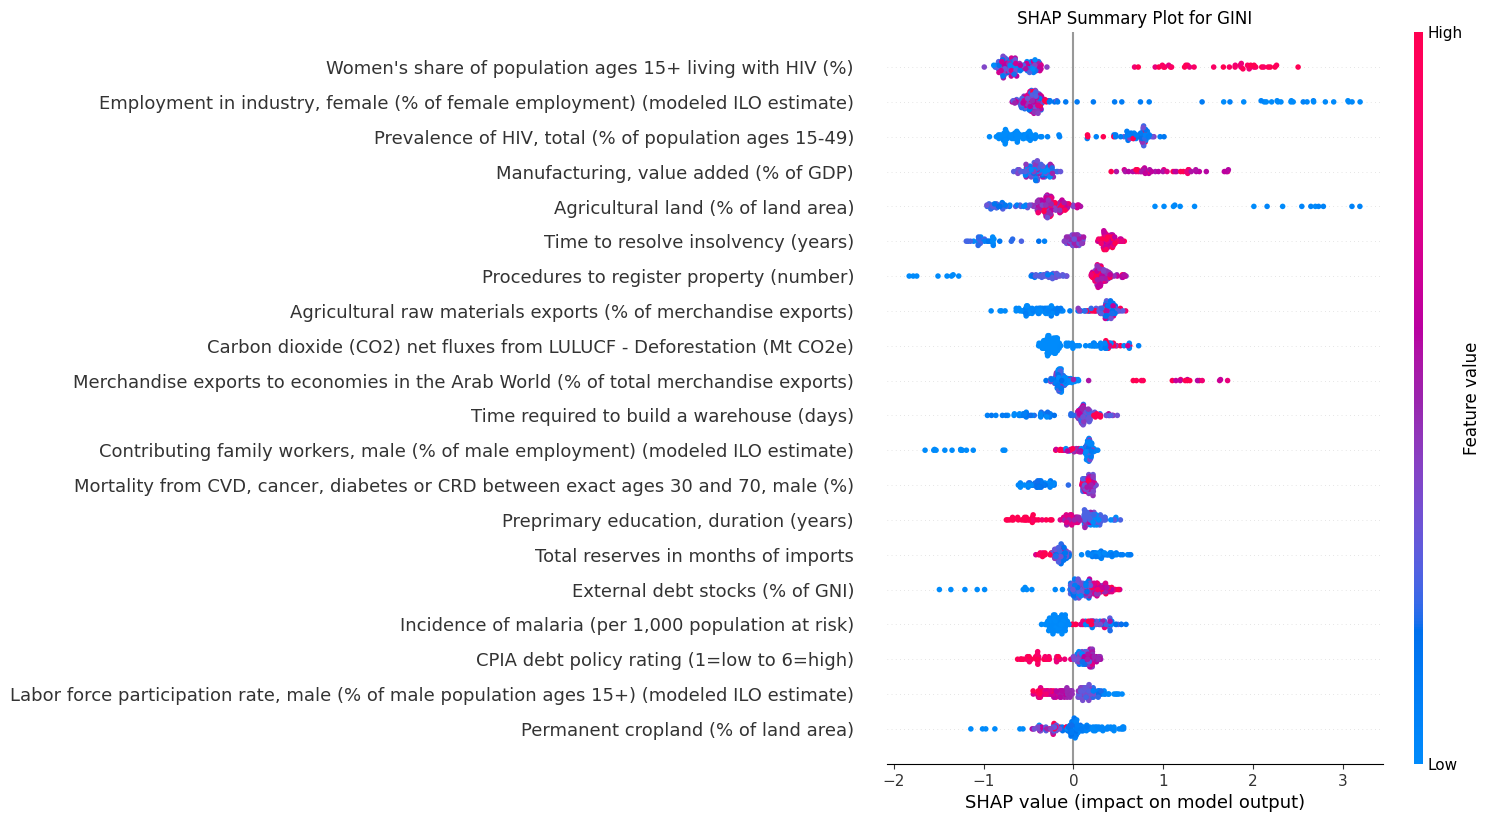

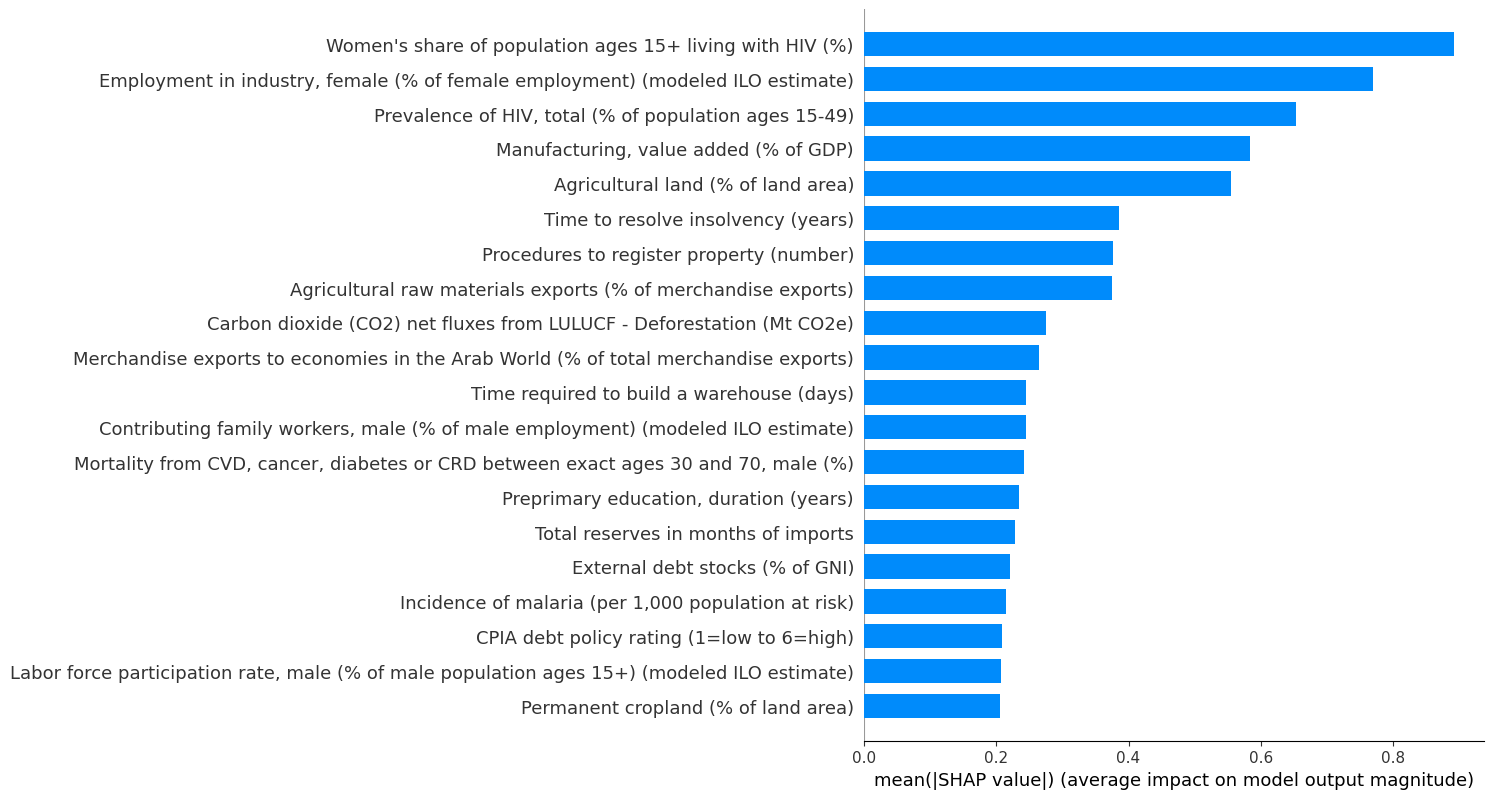


Calculating SHAP values for target: top10
SHAP values for top10 saved to output/feature_importance/shap_values_top10_multi_target_2000_to_2020.csv


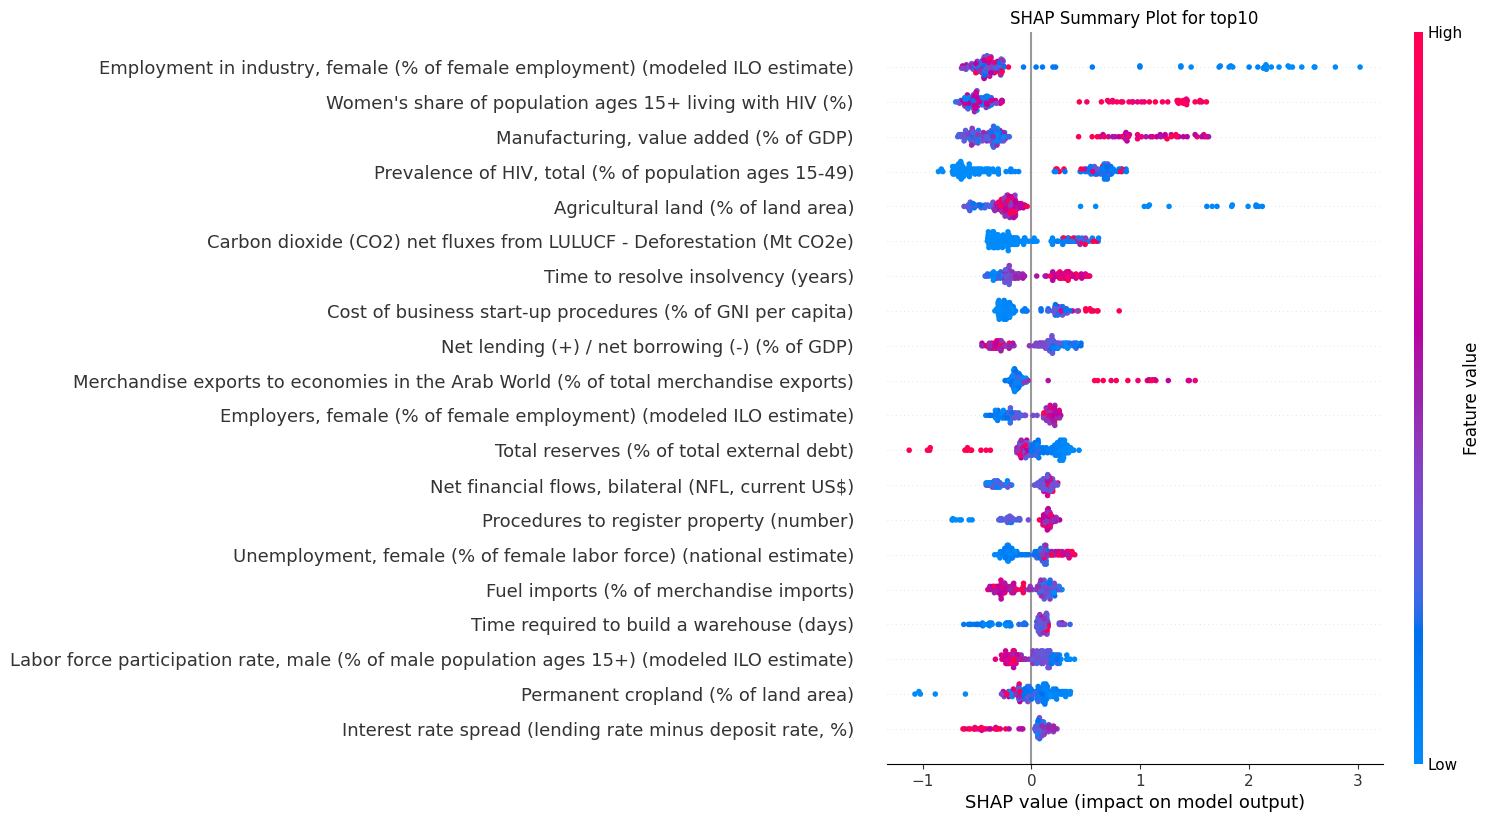

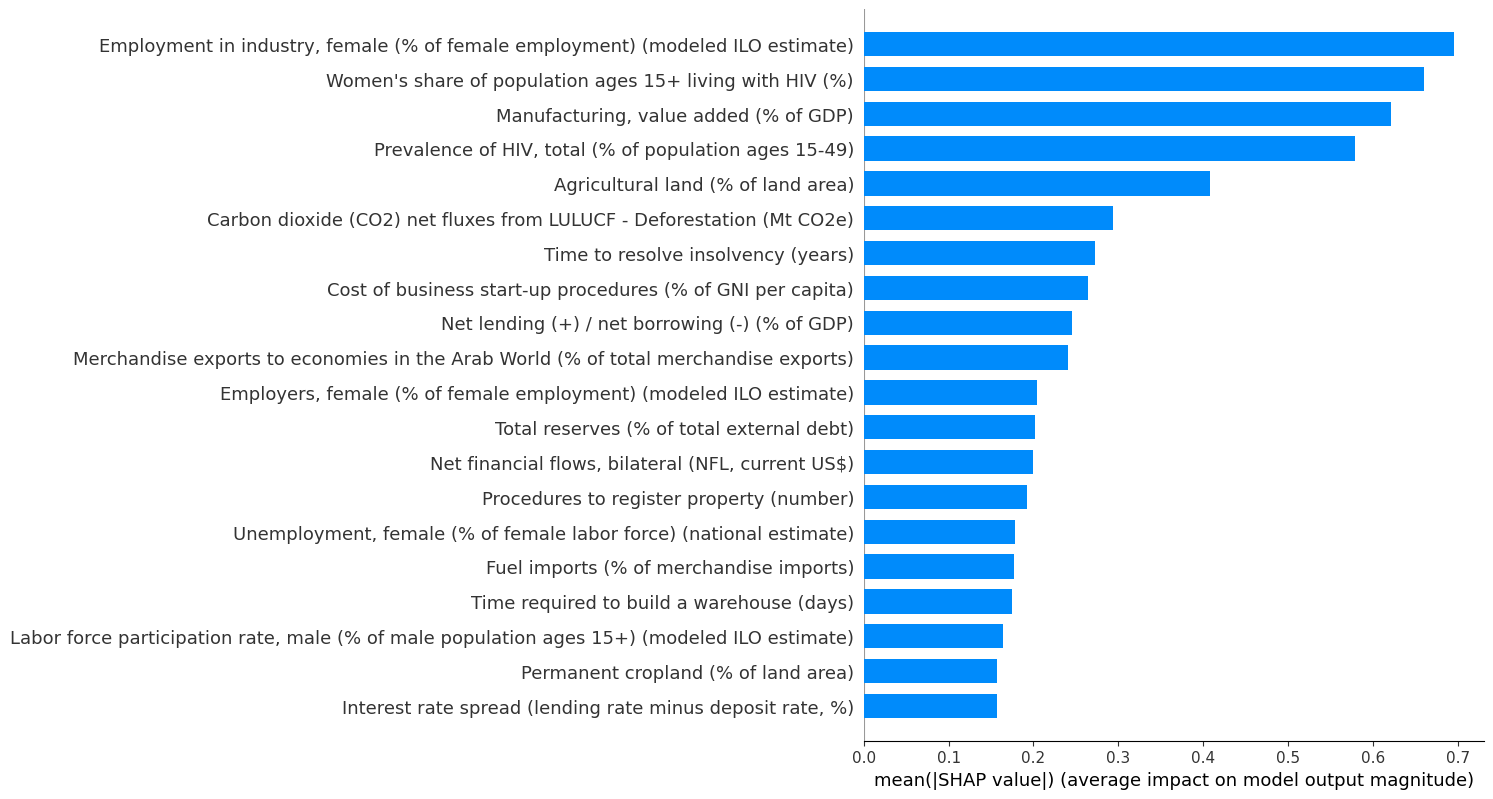


Calculating SHAP values for target: bottom10
SHAP values for bottom10 saved to output/feature_importance/shap_values_bottom10_multi_target_2000_to_2020.csv


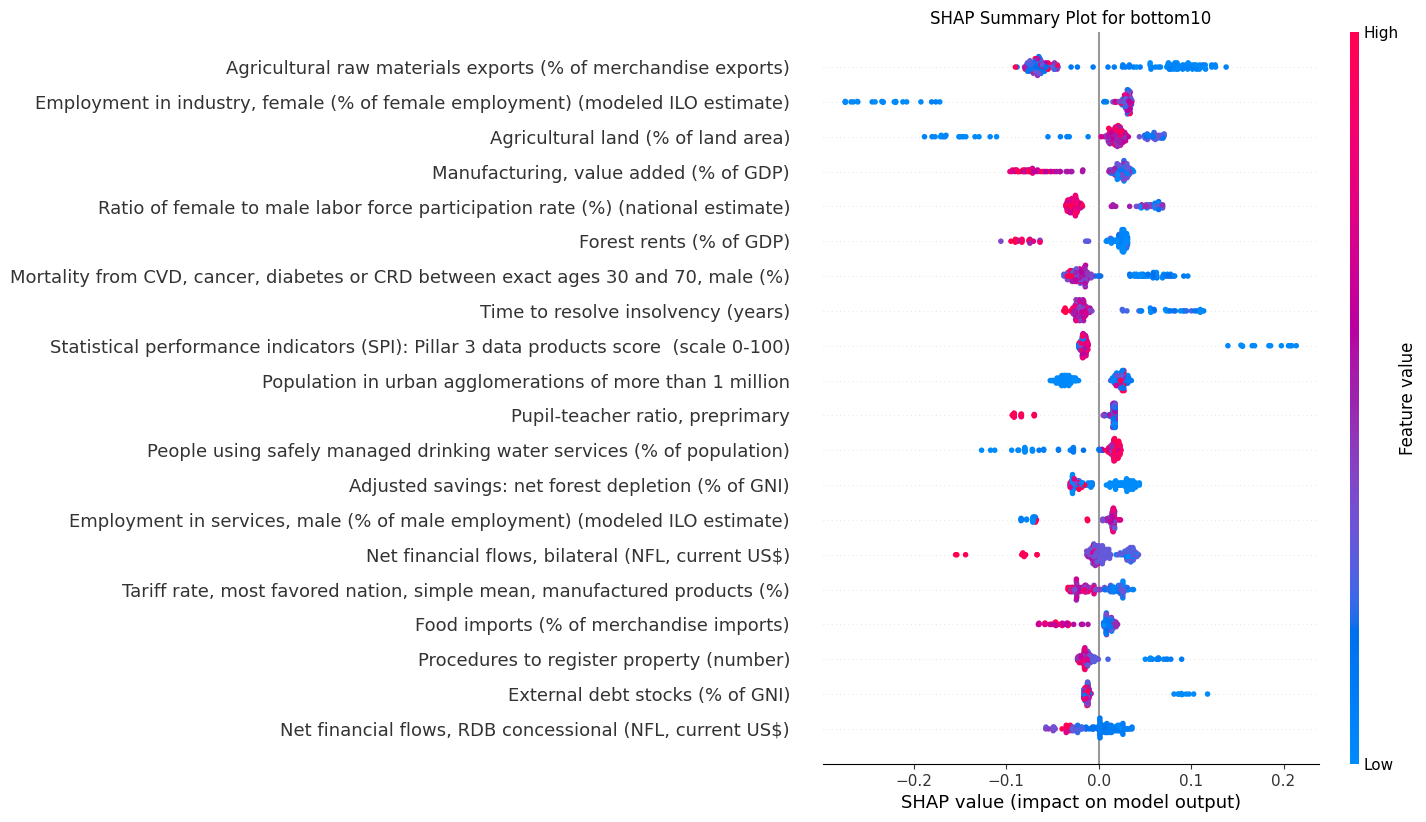

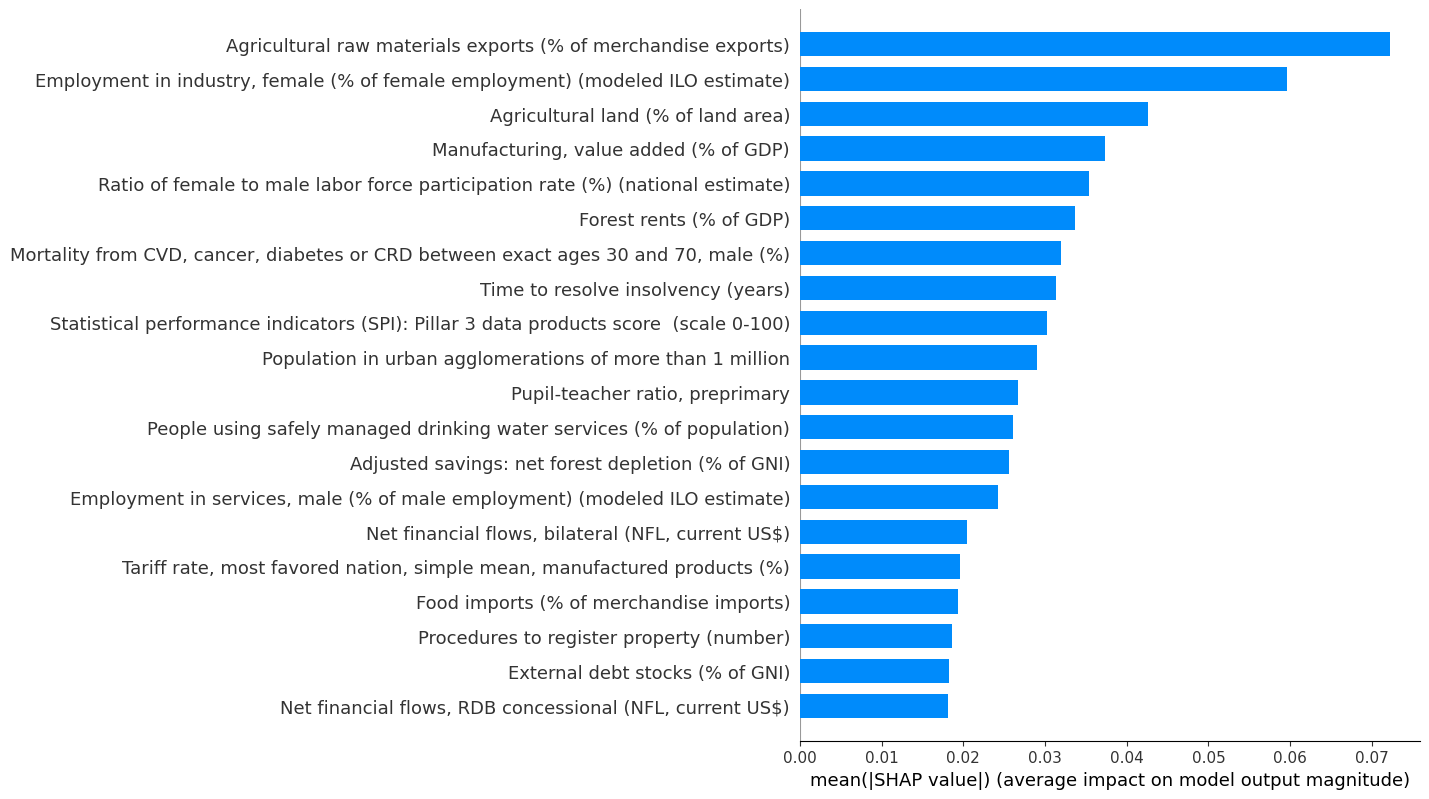


Calculating average SHAP values across all targets...
Average SHAP values saved to output/feature_importance/shap_values_avg_multi_target_2000_to_2020.csv


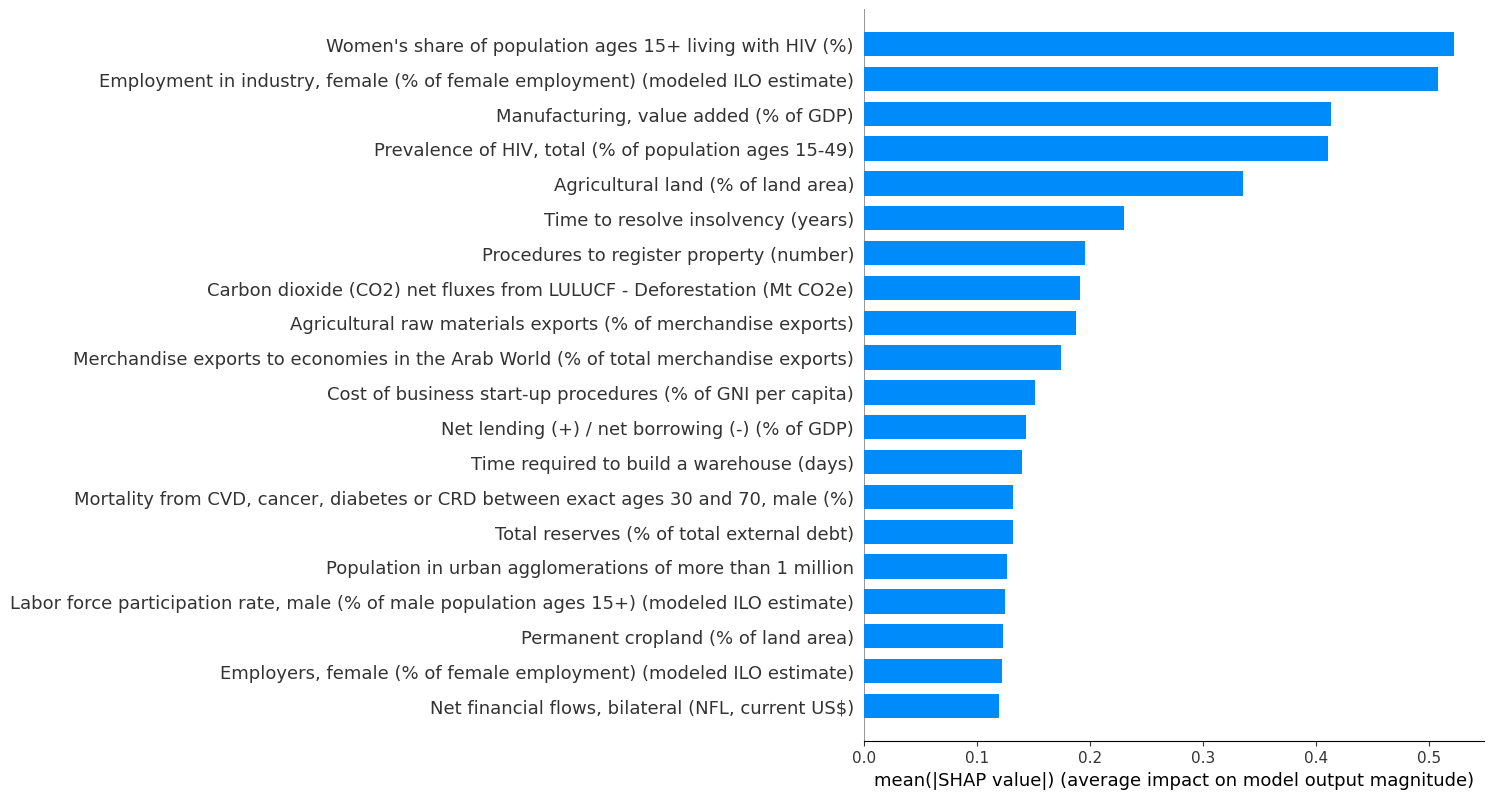

In [11]:
# SHAP analysis

# Load the indicator lookup table first
lookup = pd.read_csv(INDICATOR_LOOKUP_FILE)

# Create a mapping from Indicator Code to Indicator Name
indicator_name_mapping = dict(zip(lookup['Indicator Code'], lookup['Indicator Name']))

# Create a list of feature names for visualization (using indicator names instead of codes)
feature_names_for_display = [indicator_name_mapping.get(code, code) for code in feature_columns]

# import model if not already loaded
best_model = joblib.load(BEST_MODEL_FILE)

# Apply the scaler to transform the data first
X_test_scaled = best_model.named_steps['scaler'].transform(X_test)

# Since we have a MultiOutputRegressor, we need to handle each estimator separately
all_shap_values = []
target_shap_values = {}

# Loop through each estimator (one per target)
for i, estimator in enumerate(best_model.named_steps['model'].estimators_):
    target_name = list(TARGETS.keys())[i]
    print(f"\nCalculating SHAP values for target: {target_name}")
    
    # Initialize SHAP explainer for this target's model
    explainer = shap.TreeExplainer(estimator)
    
    # Calculate SHAP values
    shap_values_target = explainer.shap_values(X_test_scaled)
    
    # Store SHAP values for this target
    target_shap_values[target_name] = shap_values_target
    all_shap_values.append(shap_values_target)
    
    # Create a df with SHAP values for this target
    shap_values_df = pd.DataFrame(shap_values_target, columns=feature_columns)
    # Add a column with indicator names
    for col in shap_values_df.columns:
        if col in indicator_name_mapping:
            shap_values_df.rename(columns={col: f"{col} - {indicator_name_mapping[col]}"}, inplace=True)
    shap_values_df.to_csv(f'{FEATURE_IMPORTANCE_DIR}/shap_values_{target_name}_{FILE_SUFFIX}.csv', index=False)
    print(f"SHAP values for {target_name} saved to {FEATURE_IMPORTANCE_DIR}/shap_values_{target_name}_{FILE_SUFFIX}.csv")
    
    # Plot target-specific SHAP summary plot with indicator names
    plt.figure(figsize=(16, 14))  # Increased height for title space
    shap.summary_plot(shap_values_target, X_test_scaled, feature_names=feature_names_for_display, show=False)
    plt.title(f"SHAP Summary Plot for {target_name}")
    plt.savefig(f'{FEATURE_IMPORTANCE_DIR}/shap_summary_{target_name}_{FILE_SUFFIX}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create a bar plot for feature importance with indicator names
    plt.figure(figsize=(16, 14))  # Increased height for title space
    shap.summary_plot(shap_values_target, X_test_scaled, feature_names=feature_names_for_display, plot_type="bar", show=False)
    plt.savefig(f'{FEATURE_IMPORTANCE_DIR}/shap_importance_bar_{target_name}_{FILE_SUFFIX}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Calculate average SHAP values across all targets
print("\nCalculating average SHAP values across all targets...")
avg_shap_abs = np.zeros((X_test_scaled.shape[0], X_test_scaled.shape[1]))
for shap_values in all_shap_values:
    avg_shap_abs += np.abs(shap_values)
avg_shap_abs /= len(all_shap_values)

# Save the average absolute SHAP values with indicator names
avg_shap_df = pd.DataFrame(avg_shap_abs, columns=feature_columns)
# Add indicator names to the column names
renamed_columns = {col: f"{col} - {indicator_name_mapping.get(col, 'Unknown')}" for col in avg_shap_df.columns}
avg_shap_df.rename(columns=renamed_columns, inplace=True)
avg_shap_df.to_csv(f'{FEATURE_IMPORTANCE_DIR}/shap_values_avg_{FILE_SUFFIX}.csv', index=False)
print(f"Average SHAP values saved to {FEATURE_IMPORTANCE_DIR}/shap_values_avg_{FILE_SUFFIX}.csv")

# Create a summary plot of average absolute SHAP values with indicator names
plt.figure(figsize=(16, 14))  # Increased height for title space
shap.summary_plot(avg_shap_abs, X_test_scaled, feature_names=feature_names_for_display, plot_type="bar", show=False)
plt.savefig(f'{FEATURE_IMPORTANCE_DIR}/shap_importance_avg_{FILE_SUFFIX}.png', dpi=300, bbox_inches='tight')
plt.show()

# SHAP Values Final Summary

This section produces a simplified SHAP output format matching the single-target notebook

In [12]:
# SHAP analysis - Raw Output Only, similar to xgboost_randomsplit.ipynb

# Get the underlying XGBoost models from the pipeline for each target
xgb_models = best_model.named_steps['model'].estimators_

# Apply the scaler to transform the data first (if not already done)
X_test_scaled = best_model.named_steps['scaler'].transform(X_test)

# Get country information for the test set (after removing missing targets)
# We need to get this from the original test_data DataFrame using the test_mask
test_countries = test_data.loc[test_mask, ['Country Code', 'Country Name']].reset_index(drop=True)

# Calculate average SHAP values across all targets
print("\nCalculating simplified SHAP values across all targets...")

# Initialize a dictionary to store SHAP values for each target
target_shap_dfs = {}

# Calculate SHAP values for each target separately
for i, (target_name, target_code) in enumerate(TARGETS.items()):
    # Initialize SHAP explainer for this target's model
    explainer = shap.TreeExplainer(xgb_models[i])
    
    # Calculate SHAP values for this target
    shap_values = explainer.shap_values(X_test_scaled)
    
    # Create a DataFrame with SHAP values and feature names
    shap_df = pd.DataFrame(shap_values, columns=feature_columns)
    
    # Save the raw SHAP values with country information for this target
    shap_with_countries = pd.concat([test_countries, shap_df], axis=1)
    shap_with_countries.to_csv(f'{FEATURE_IMPORTANCE_DIR}/shap_values_with_countries_{target_name.lower()}_{DATE_RANGE}.csv', index=False)
    print(f"SHAP values with country labels for {target_name} saved to {FEATURE_IMPORTANCE_DIR}/shap_values_with_countries_{target_name.lower()}_{DATE_RANGE}.csv")
    
    # Also save the SHAP values without countries for backward compatibility
    shap_df.to_csv(f'{FEATURE_IMPORTANCE_DIR}/shap_values_{target_name.lower()}_{DATE_RANGE}.csv', index=False)
    print(f"SHAP values for {target_name} saved to {FEATURE_IMPORTANCE_DIR}/shap_values_{target_name.lower()}_{DATE_RANGE}.csv")
    
    # Store the DataFrame in our dictionary for later use
    target_shap_dfs[target_name.lower()] = shap_df

# Function to replace indicator codes with names
def replace_code_with_name(df, feature_lookup):
    # Create a dictionary mapping from indicator codes to names
    code_to_name = dict(zip(feature_lookup['Indicator Code'], feature_lookup['Indicator Name']))
    
    # Create a copy of the DataFrame to avoid modifying the original
    renamed_df = df.copy()
    
    # For each column that exists in our lookup, rename it
    columns_to_rename = {}
    for col in renamed_df.columns:
        if col in code_to_name:
            columns_to_rename[col] = code_to_name[col]
    
    # Apply the renaming
    renamed_df = renamed_df.rename(columns=columns_to_rename)
    
    return renamed_df

# Replace codes with names in the SHAP DataFrames
shap_gini = replace_code_with_name(target_shap_dfs['gini'], feature_lookup)
shap_top10 = replace_code_with_name(target_shap_dfs['top10'], feature_lookup)
shap_bottom10 = replace_code_with_name(target_shap_dfs['bottom10'], feature_lookup)

# Function to get the top 10 features by SHAP value magnitude
def get_top_features(shap_df, n=10):
    # Calculate the mean absolute SHAP value for each feature across all samples
    feature_importance = pd.Series(np.abs(shap_df).mean(), index=shap_df.columns)
    
    # Sort by absolute importance and get top n
    top_features = feature_importance.sort_values(ascending=False).head(n)
    
    return top_features

# Get top 10 features for each target variable
top_gini_features = get_top_features(shap_gini)
top_top10_features = get_top_features(shap_top10)
top_bottom10_features = get_top_features(shap_bottom10)

# Display the results
print("\nTop 10 features for GINI coefficient:")
display(top_gini_features)

print("\nTop 10 features for Top 10% wealth share:")
display(top_top10_features)

print("\nTop 10 features for Bottom 10% wealth share:")
display(top_bottom10_features)

# Create a comparison DataFrame to see overlap between important features
comparison = pd.DataFrame({
    'GINI': top_gini_features,
    'Top 10%': top_top10_features,
    'Bottom 10%': top_bottom10_features
})

print("\nComparison of top feature importance values:")
display(comparison)

# Save the comparison to CSV for future reference
comparison.to_csv(f'{FEATURE_IMPORTANCE_DIR}/top_features_comparison_xgboost_multi_rs_{DATE_RANGE}.csv', index=True)
print(f"\nComparison saved to {FEATURE_IMPORTANCE_DIR}/top_features_comparison_xgboost_multi_rs_{DATE_RANGE}.csv")


Calculating simplified SHAP values across all targets...
SHAP values with country labels for GINI saved to output/feature_importance/shap_values_with_countries_gini_2000_to_2020.csv
SHAP values for GINI saved to output/feature_importance/shap_values_gini_2000_to_2020.csv
SHAP values with country labels for top10 saved to output/feature_importance/shap_values_with_countries_top10_2000_to_2020.csv
SHAP values for top10 saved to output/feature_importance/shap_values_top10_2000_to_2020.csv
SHAP values with country labels for bottom10 saved to output/feature_importance/shap_values_with_countries_bottom10_2000_to_2020.csv
SHAP values for bottom10 saved to output/feature_importance/shap_values_bottom10_2000_to_2020.csv

Top 10 features for GINI coefficient:
SHAP values with country labels for top10 saved to output/feature_importance/shap_values_with_countries_top10_2000_to_2020.csv
SHAP values for top10 saved to output/feature_importance/shap_values_top10_2000_to_2020.csv
SHAP values with co

Women's share of population ages 15+ living with HIV (%)                               0.891842
Employment in industry, female (% of female employment) (modeled ILO estimate)         0.768996
Prevalence of HIV, total (% of population ages 15-49)                                  0.652474
Manufacturing, value added (% of GDP)                                                  0.583211
Agricultural land (% of land area)                                                     0.554780
Time to resolve insolvency (years)                                                     0.385566
Procedures to register property (number)                                               0.376114
Agricultural raw materials exports (% of merchandise exports)                          0.375645
Carbon dioxide (CO2) net fluxes from LULUCF - Deforestation (Mt CO2e)                  0.276017
Merchandise exports to economies in the Arab World (% of total merchandise exports)    0.265329
dtype: float32


Top 10 features for Top 10% wealth share:


Employment in industry, female (% of female employment) (modeled ILO estimate)         0.695803
Women's share of population ages 15+ living with HIV (%)                               0.660289
Manufacturing, value added (% of GDP)                                                  0.620833
Prevalence of HIV, total (% of population ages 15-49)                                  0.579011
Agricultural land (% of land area)                                                     0.408358
Carbon dioxide (CO2) net fluxes from LULUCF - Deforestation (Mt CO2e)                  0.294314
Time to resolve insolvency (years)                                                     0.272937
Cost of business start-up procedures (% of GNI per capita)                             0.263783
Net lending (+) / net borrowing (-) (% of GDP)                                         0.245838
Merchandise exports to economies in the Arab World (% of total merchandise exports)    0.241195
dtype: float32


Top 10 features for Bottom 10% wealth share:


Agricultural raw materials exports (% of merchandise exports)                            0.072256
Employment in industry, female (% of female employment) (modeled ILO estimate)           0.059646
Agricultural land (% of land area)                                                       0.042636
Manufacturing, value added (% of GDP)                                                    0.037366
Ratio of female to male labor force participation rate (%) (national estimate)           0.035357
Forest rents (% of GDP)                                                                  0.033670
Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70, male (%)       0.031970
Time to resolve insolvency (years)                                                       0.031399
Statistical performance indicators (SPI): Pillar 3 data products score  (scale 0-100)    0.030191
Population in urban agglomerations of more than 1 million                                0.029031
dtype: float32


Comparison of top feature importance values:


,GINI,Top 10%,Bottom 10%
Agricultural land (% of land area),0.554780,0.408358,0.042636
Agricultural raw materials exports (% of merchandise exports),0.375645,NaN,0.072256
Carbon dioxide (CO2) net fluxes from LULUCF - Deforestation (Mt CO2e),0.276017,0.294314,NaN
Cost of business start-up procedures (% of GNI per capita),NaN,0.263783,NaN
"Employment in industry, female (% of female employment) (modeled ILO estimate)",0.768996,0.695803,0.059646
Forest rents (% of GDP),NaN,NaN,0.033670
"Manufacturing, value added (% of GDP)",0.583211,0.620833,0.037366
Merchandise exports to economies in the Arab World (% of total merchandise exports),0.265329,0.241195,NaN
"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70, male (%)",NaN,NaN,0.031970
Net lending (+) / net borrowing (-) (% of GDP),NaN,0.245838,NaN



Comparison saved to output/feature_importance/top_features_comparison_xgboost_multi_rs_2000_to_2020.csv
